In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from trading.utils import *
from trading.strategy import *
from trading.trader import *
import warnings
warnings.filterwarnings("ignore")



# Load historical stock data
data = pd.read_csv('data/us_stock/AAPL.csv', parse_dates=['Date'], index_col='Date')

data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.253260,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.874275,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,16.966295,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.844961,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.951632,258529600


In [30]:
# Create features and labels
new_data = calculate_indicators_df(data)

# Label: 1 if the price goes up the next day, 0 otherwise
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

new_data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_50,EMA_10,EMA_50,...,True_Range,ATR,ROC,Stochastic,Lag_1,Lag_5,Lag_10,Rolling_Std_10,Rolling_Std_30,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-14,18.885357,18.960358,18.678572,18.738930,16.464128,237199200,18.969679,19.002064,18.942885,19.051090,...,0.281786,0.276760,-0.002945,37.780708,-0.011231,-0.010840,-0.002945,0.124788,0.408421,1
2014-03-17,18.846430,18.927500,18.780357,18.812143,16.528448,199544800,18.966036,18.983214,18.919114,19.041720,...,0.188570,0.268367,-0.001933,46.300995,0.003907,-0.007873,-0.001933,0.129171,0.366890,1
2014-03-18,18.782143,18.998928,18.757143,18.978571,16.674679,209647200,18.966607,18.976371,18.929924,19.039243,...,0.241785,0.261658,0.000301,65.014805,0.008847,-0.008749,0.000301,0.129218,0.320476,0
2014-03-19,19.009287,19.151428,18.892857,18.973572,16.670279,224756000,18.962679,18.967322,18.937860,19.036668,...,0.258572,0.247653,-0.002066,52.109588,-0.000263,-0.009970,-0.002066,0.128249,0.289858,0
2014-03-20,18.924643,19.023930,18.833929,18.882143,16.589951,208398400,18.955357,18.959221,18.927730,19.030608,...,0.190001,0.234107,-0.003862,34.955580,-0.004819,-0.003675,-0.003862,0.130778,0.265682,1


In [31]:
new_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_10',
       'SMA_50', 'EMA_10', 'EMA_50', 'Momentum', 'RSI', 'EMA_12', 'EMA_26',
       'MACD', 'MACD_Signal', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'High_Low',
       'High_Close', 'Low_Close', 'True_Range', 'ATR', 'ROC', 'Stochastic',
       'Lag_1', 'Lag_5', 'Lag_10', 'Rolling_Std_10', 'Rolling_Std_30',
       'Target'],
      dtype='object')

In [32]:
# Features and target
selected_features = ['Close', 'SMA_10', 'SMA_50', 'Momentum']
X = new_data[selected_features]
y = new_data['Target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Save the scaler and model
import joblib
joblib.dump(scaler, 'model/scaler.pkl')
joblib.dump(model, 'model/logistic_model.pkl')

Accuracy: 0.515527950310559


['model/logistic_model.pkl']

In [33]:
class MLTradingStrategy(bt.Strategy):
    """
    A strategy that uses a machine learning model to predict buy/sell signals.
    """
    def __init__(self):
        # Load the pre-trained model and scaler
        self.model = joblib.load('model/logistic_model.pkl')
        self.scaler = joblib.load('model/scaler.pkl')
        
        # Initialize indicators
        self.indicators = calculate_indicators_bt(self.data)
        self.selected_features = selected_features
        
    def next(self):
        # Create feature set for prediction
        features = [[self.indicators[feature][0] for feature in self.selected_features]]
        features = self.scaler.transform(features)  # Scale features

        # Get prediction
        prediction = self.model.predict(features)[0]  # 1 for buy, 0 for sell

        if not self.position:  # Not in a position
            if prediction == 1:
                self.buy()
                self.log(f'BUY CREATE {self.data.close[0]:.2f}')
        else:  # In a position
            if prediction == 0:
                self.sell()
                self.log(f'SELL CREATE {self.data.close[0]:.2f}')
    
    def log(self, txt, dt=None):
        """Logging function for this strategy"""
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')

In [34]:
# Initialize the AITrader
trader = AITrader(start_date="2020-01-01", end_date="2021-01-01")

# Set your desired strategy; for example, using the BuyHoldStrategy
trader.add_strategy(MLTradingStrategy)

# Run the backtest
trader.run(1, stock_ticker="AAPL")


--- AITrader initialization ---
Strategy 'MLTradingStrategy' added without parameters.
Data loaded.
Starting Value: 1000000
Sizer set to 95%.
Analyzers added.

--- Backtesting ---
2020-03-13 - BUY CREATE 69.49
2020-08-31 - SELL CREATE 129.04
2020-09-03 - BUY CREATE 120.88
Ending value: 2178370
Total Returns: 0.78
Annualized Returns: 1.17
Max Drawdown: 11.89%

--- Strategy Evaluation ---
Total Returns are positive, indicating a profitable strategy.
Max Drawdown is within acceptable limits (< 20%), suggesting a stable strategy.


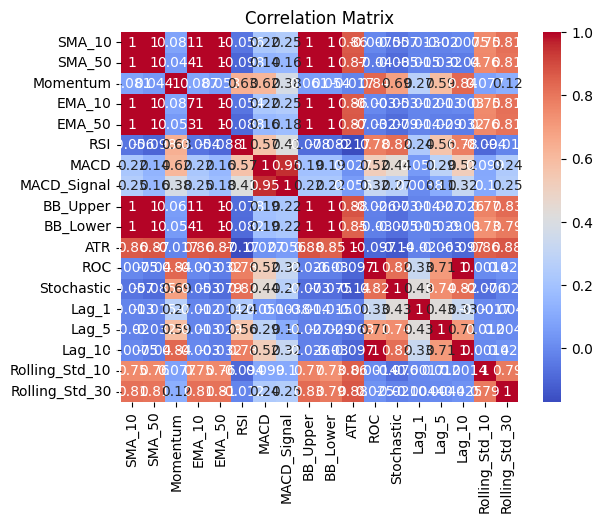

Selected Features: Index(['Momentum', 'EMA_10', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal',
       'BB_Upper', 'Stochastic', 'Lag_1', 'Lag_10'],
      dtype='object')
Accuracy with Selected Features: 0.5204968944099378
Cross-Validation Accuracy Scores: [0.48670213 0.536      0.53333333 0.528      0.512     ]
Mean Cross-Validation Score: 0.5192070921985816


In [35]:
# Feature matrix and target vector
X = new_data[['SMA_10', 'SMA_50', 'Momentum', 'EMA_10', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal',
          'BB_Upper', 'BB_Lower', 'ATR', 'ROC', 'Stochastic', 'Lag_1', 
          'Lag_5', 'Lag_10', 'Rolling_Std_10', 'Rolling_Std_30']]
y = new_data['Target']

# Correlation Analysis
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Feature Selection
# Drop one feature from each highly correlated pair (correlation > 0.85)
# For example, if 'SMA_50' and 'SMA_10' are highly correlated
X = X.drop(['SMA_50'], axis=1) if correlation_matrix.loc['SMA_10', 'SMA_50'] > 0.85 else X

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Recursive Feature Elimination (RFE)
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=log_reg, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Selected Features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Train logistic regression model
model_rfe = LogisticRegression(max_iter=1000)
model_rfe.fit(X_train_rfe, y_train)

# Model Evaluation
y_pred = model_rfe.predict(X_test_rfe)
print("Accuracy with Selected Features:", accuracy_score(y_test, y_pred))

# Cross-Validation
cv_scores = cross_val_score(model_rfe, X_train_rfe, y_train, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))
